<a href="https://colab.research.google.com/github/preethinihar/image-captioning/blob/main/final_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


Loading captions...
Extracting image features...


100%|██████████| 334/334 [00:40<00:00,  8.28it/s]


Preparing tokenizer...
Building model...
Preparing dataset...
Training model...
Epoch 1/20
316/316 ━━━━━━━━━━━━━━━━━━━━ 15s 33ms/step - loss: 5.8466
Epoch 2/20
316/316 ━━━━━━━━━━━━━━━━━━━━ 21s 36ms/step - loss: 3.9013
Epoch 3/20
316/316 ━━━━━━━━━━━━━━━━━━━━ 12s 36ms/step - loss: 3.1765
Epoch 4/20
316/316 ━━━━━━━━━━━━━━━━━━━━ 12s 35ms/step - loss: 2.6381
Epoch 5/20
316/316 ━━━━━━━━━━━━━━━━━━━━ 12s 35ms/step - loss: 2.2591
Epoch 6/20
316/316 ━━━━━━━━━━━━━━━━━━━━ 20s 35ms/step - loss: 1.9611
Epoch 7/20
316/316 ━━━━━━━━━━━━━━━━━━━━ 12s 33ms/step - loss: 1.7296
Epoch 8/20
316/316 ━━━━━━━━━━━━━━━━━━━━ 21s 35ms/step - loss: 1.5659
Epoch 9/20
316/316 ━━━━━━━━━━━━━━━━━━━━ 20s 35ms/step - loss: 1.4214
Epoch 10/20
316/316 ━━━━━━━━━━━━━━━━━━━━ 20s 33ms/step - loss: 1.2890
Epoch 11/20
316/316 ━━━━━━━━━━━━━━━━━━━━ 12s 35ms/step - loss: 1.1750
Epoch 12/20
316/316 ━━━━━━━━━━━━━━━━━━━━ 20s 35ms/step - loss: 1.0873
Epoch 13/20
316/316 ━━━━━━━━━━━━━━━━━━━━ 12s 35ms/step - loss: 0.9862
Epoch 14/20
316/316

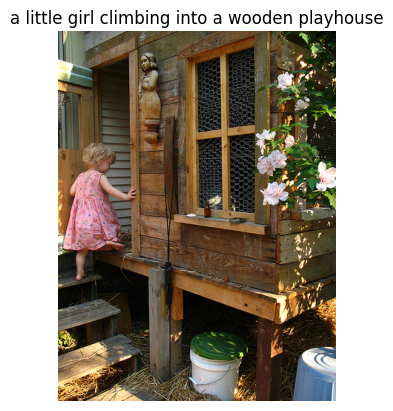

In [ ]:
import os
import string
import numpy as np
import tensorflow as tf
from tqdm import tqdm
from collections import defaultdict
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.applications.efficientnet import EfficientNetB0, preprocess_input
from tensorflow.keras.layers import Input, Dense, LSTM, Embedding, Dropout, add
from tensorflow.keras.models import Model
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing import image
import matplotlib.pyplot as plt
from PIL import Image

# =========================
# CONFIGURATION
# =========================
DATA_DIR = '/content/drive/MyDrive/archive (5)/Images'  # <-- Update this
CAPTION_FILE = '/content/Flickr8k.token.txt'  # <-- Update this

VOCAB_SIZE = 10000
MAX_LENGTH = 40
EMBEDDING_DIM = 256
LSTM_UNITS = 256
BATCH_SIZE = 64
EPOCHS = 20

# =========================
# LOAD & CLEAN CAPTIONS
# =========================
def load_captions(caption_file):
    captions_dict = defaultdict(list)
    with open(caption_file, 'r') as f:
        for line in f:
            tokens = line.strip().split('\t')
            img_id, caption = tokens[0].split('#')[0].strip(), tokens[1]
            caption = caption.lower().translate(str.maketrans('', '', string.punctuation))
            caption = 'startseq ' + caption + ' endseq'
            captions_dict[img_id].append(caption)
    return captions_dict

# =========================
# EXTRACT FEATURES
# =========================
def extract_image_features(image_dir, image_list):
    model = EfficientNetB0(weights='imagenet', include_top=False, pooling='avg')
    features = {}
    for img_name in tqdm(image_list):
        img_path = os.path.join(image_dir, img_name)
        if not os.path.exists(img_path):
            continue
        try:
            img = image.load_img(img_path, target_size=(224, 224))
            img_array = image.img_to_array(img)
            img_array = np.expand_dims(img_array, axis=0)
            img_array = preprocess_input(img_array)
            feature = model.predict(img_array, verbose=0)
            features[img_name] = feature
        except Exception as e:
            print(f"Error with {img_name}: {e}")
    return features

# =========================
# TOKENIZER
# =========================
def create_tokenizer(captions, vocab_size):
    tokenizer = Tokenizer(num_words=vocab_size, oov_token='<unk>', filters='!"#$%&()*+.,-/:;=?@[\]^_`{|}~ ')
    tokenizer.fit_on_texts(captions)
    return tokenizer

# =========================
# DATA GENERATOR
# =========================
def data_generator(image_features, captions_dict, tokenizer, max_length, vocab_size):
    for img_id, captions in captions_dict.items():
        if img_id not in image_features:
            continue
        for caption in captions:
            seq = tokenizer.texts_to_sequences([caption])[0]
            for i in range(1, len(seq)):
                in_seq, out_seq = seq[:i], seq[i]
                in_seq = pad_sequences([in_seq], maxlen=max_length, padding='post')[0]
                out_seq = to_categorical([out_seq], num_classes=vocab_size)[0]
                img_feature = image_features[img_id][0]
                yield (img_feature, in_seq), out_seq

# =========================
# BUILD MODEL #embedding layer-converts tokens into dense vectors
# =========================
def build_decoder(vocab_size, max_length, embedding_dim, units):
    inputs1 = Input(shape=(1280,))
    fe1 = Dropout(0.4)(inputs1)
    fe2 = Dense(units, activation='relu')(fe1)

    inputs2 = Input(shape=(max_length,))
    se1 = Embedding(vocab_size, embedding_dim, mask_zero=True)(inputs2)
    se2 = Dropout(0.4)(se1)
    se3 = LSTM(units)(se2)

    decoder1 = add([fe2, se3])
    decoder2 = Dense(units, activation='relu')(decoder1)
    outputs = Dense(vocab_size, activation='softmax')(decoder2)

    model = Model(inputs=[inputs1, inputs2], outputs=outputs)
    return model

# =========================
# GENERATE CAPTION
# =========================
def generate_caption(model, tokenizer, photo, max_length):
    in_text = 'startseq'
    for _ in range(max_length):
        sequence = tokenizer.texts_to_sequences([in_text])[0]
        sequence = pad_sequences([sequence], maxlen=max_length, padding='post')
        yhat = model.predict([photo, sequence], verbose=0)
        yhat = np.argmax(yhat)
        word = tokenizer.index_word.get(yhat)
        if word is None or word == 'endseq':
            break
        in_text += ' ' + word
    return in_text.replace('startseq', '').strip()

# =========================
# MAIN
# =========================
if __name__ == "__main__":
    print("Loading captions...")
    captions_dict = load_captions(CAPTION_FILE)
    image_list = [img for img in captions_dict.keys() if os.path.exists(os.path.join(DATA_DIR, img))]

    print("Extracting image features...")
    image_features = extract_image_features(DATA_DIR, image_list)

    print("Preparing tokenizer...")
    all_captions = [caption for caps in captions_dict.values() for caption in caps]
    tokenizer = create_tokenizer(all_captions, VOCAB_SIZE)

    print("Building model...")
    model = build_decoder(VOCAB_SIZE, MAX_LENGTH, EMBEDDING_DIM, LSTM_UNITS)
    model.compile(loss='categorical_crossentropy', optimizer='adam')

    print("Preparing dataset...")
    dataset = tf.data.Dataset.from_generator(
        lambda: data_generator(image_features, captions_dict, tokenizer, MAX_LENGTH, VOCAB_SIZE),
        output_signature=(
            (
                tf.TensorSpec(shape=(1280,), dtype=tf.float32),
                tf.TensorSpec(shape=(MAX_LENGTH,), dtype=tf.int32)
            ),
            tf.TensorSpec(shape=(VOCAB_SIZE,), dtype=tf.float32)
        )
    ).shuffle(2048).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

    print("Training model...")
    model.fit(dataset, epochs=EPOCHS)

    print("\nGenerating caption for test image...")
    test_img = list(image_features.keys())[0]
    test_feat = image_features[test_img]
    caption = generate_caption(model, tokenizer, test_feat, MAX_LENGTH)

    img_path = os.path.join(DATA_DIR, test_img)
    img = Image.open(img_path)

    plt.imshow(img)
    plt.axis('off')
    plt.title(caption)
    plt.show()

In [ ]:
pip install nltk rouge-score


In [ ]:
from nltk.translate.bleu_score import sentence_bleu, corpus_bleu
from nltk.translate.meteor_score import meteor_score
from rouge_score import rouge_scorer


ModuleNotFoundError: No module named 'rouge_score'

In [ ]:
def evaluate_model(model, captions_dict, image_features, tokenizer, max_length):
    from nltk.translate.bleu_score import corpus_bleu
    from nltk.translate.meteor_score import meteor_score
    from rouge_score import rouge_scorer
    import numpy as np
    from tqdm import tqdm

    references = []
    hypotheses = []

    rouge = rouge_scorer.RougeScorer(['rouge1', 'rougeL'], use_stemmer=True)
    meteor_scores, rouge1_scores, rougeL_scores = [], [], []

    for img_id, refs in tqdm(captions_dict.items(), desc="Evaluating"):
        if img_id not in image_features:
            continue
        photo = image_features[img_id]
        pred = generate_caption(model, tokenizer, photo, max_length)

        tokenized_refs = [r.split() for r in refs]
        tokenized_pred = pred.split()

        references.append(tokenized_refs)
        hypotheses.append(tokenized_pred)

        meteor_scores.append(meteor_score(tokenized_refs, tokenized_pred))
        rouge_scores = rouge.score(refs[0], pred)
        rouge1_scores.append(rouge_scores['rouge1'].fmeasure)
        rougeL_scores.append(rouge_scores['rougeL'].fmeasure)

    print("\nEvaluation Metrics:")
    print("BLEU-1:", corpus_bleu(references, hypotheses, weights=(1.0, 0, 0, 0)))
    print("BLEU-2:", corpus_bleu(references, hypotheses, weights=(0.5, 0.5, 0, 0)))
    print("BLEU-3:", corpus_bleu(references, hypotheses, weiaghts=(0.33, 0.33, 0.33, 0)))
    print("BLEU-4:", corpus_bleu(references, hypotheses, weights=(0.25, 0.25, 0.25, 0.25)))
    print("METEOR:", np.mean(meteor_scores))
    print("ROUGE-1:", np.mean(rouge1_scores))
    print("ROUGE-L:", np.mean(rougeL_scores))


In [ ]:
evaluate_model(model, captions_dict, image_features, tokenizer, MAX_LENGTH)


Evaluating: 100%|██████████| 8092/8092 [05:09<00:00, 26.13it/s] 



Evaluation Metrics:
BLEU-1: 0.9324750851611081
BLEU-2: 0.9181143661783017
BLEU-3: 0.8964571902316217
BLEU-4: 0.8707205309170023
METEOR: 0.7601087040285966
ROUGE-1: 0.4725687729333427
ROUGE-L: 0.45008445309630263


In [ ]:
pip install streamlit


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.3/44.3 kB 3.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.9/9.9 MB 123.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.9/6.9 MB 132.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.1/79.1 kB 7.3 MB/s eta 0:00:00


In [ ]:
!pip install streamlit
!pip install pyngrok


In [ ]:
!pip install streamlit pyngrok tensorflow pillow


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.3/44.3 kB 2.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.9/9.9 MB 35.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.9/6.9 MB 32.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.1/79.1 kB 2.9 MB/s eta 0:00:00


In [ ]:
!pip install gradio


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.1/54.1 MB 14.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 322.9/322.9 kB 19.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 95.2/95.2 kB 6.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.5/11.5 MB 104.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 72.0/72.0 kB 4.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.5/62.5 kB 4.4 MB/s eta 0:00:00


In [ ]:
!pip install gradio
import gradio as gr
from transformers import BlipProcessor, BlipForConditionalGeneration
from PIL import Image
import torch

# Load the pretrained BLIP model and processor
processor = BlipProcessor.from_pretrained("Salesforce/blip-image-captioning-base")
model = BlipForConditionalGeneration.from_pretrained("Salesforce/blip-image-captioning-base")

# Caption generation function
def generate_caption(image):
    inputs = processor(images=image, return_tensors="pt")
    out = model.generate(**inputs)
    caption = processor.decode(out[0], skip_special_tokens=True)
    return caption

# Gradio interface
iface = gr.Interface(
    fn=generate_caption,
    inputs=gr.Image(type="pil"),
    outputs=gr.Textbox(),
)

iface.launch(share=True)


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.2/54.2 MB 9.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 323.1/323.1 kB 23.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 95.2/95.2 kB 6.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.6/11.6 MB 38.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 72.0/72.0 kB 5.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.5/62.5 kB 2.5 MB/s eta 0:00:00


Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.
/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


preprocessor_config.json:   0%|          | 0.00/287 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/506 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/711k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/125 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/4.56k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/990M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/990M [00:00<?, ?B/s]

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://6920306da01f3b38b2.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)
